# Volumetric heat maps

In [1]:
samples = 10

In [2]:
import time
import random
import math
import numpy as np

In [3]:
%env QRACK_QUNITMULTI_DEVICES 1
from pyqrack import QrackSimulator, QrackCircuit

env: QRACK_QUNITMULTI_DEVICES=1


In [4]:
def mcx(circ, c, q):
    circ.ucmtrx([c], [0, 1, 1, 0], q, 1)

def mcy(circ, c, q):
    circ.ucmtrx([c], [0, -1j, 1j, 0], q, 1)

def mcz(circ, c, q):
    circ.ucmtrx([c], [1, 0, 0, -1], q, 1)

def macx(circ, c, q):
    circ.ucmtrx([c], [0, 1, 1, 0], q, 0)

def macy(circ, c, q):
    circ.ucmtrx([c], [0, -1j, 1j, 0], q, 0)

def macz(circ, c, q):
    circ.ucmtrx([c], [1, 0, 0, -1], q, 0)

def rand_u3(circ, q):
    th = random.uniform(0, 4 * math.pi)
    ph = random.uniform(0, 4 * math.pi)
    lm = random.uniform(0, 4 * math.pi)

    c = math.cos(th / 2)
    s = math.sin(th / 2)

    op = []
    op.append(c)
    op.append(-np.exp(1j * lm) * s)
    op.append(np.exp(1j * ph) * s)
    op.append(np.exp(1j * (ph + lm)) * c)

    circ.mtrx(op, q)

def bench(width, depth, sdrp):
    sim = QrackSimulator(width)
    sim.set_sdrp(sdrp)
    gateSequence = [ 0, 3, 2, 1, 2, 1, 0, 3 ]
    two_qubit_gates = mcx, mcy, mcz, macx, macy, macz
    
    colLen = math.floor(math.sqrt(width))
    while ((math.floor(width / colLen) * colLen) != width):
        colLen = colLen - 1
    rowLen = width // colLen;

    time_results = []
    fidelity_results = []

    for _ in range(samples):
        circ = QrackCircuit()
        d_time_results = []
        d_fidelity_results = []
        
        for i in range(depth):
            # Single bit gates
            for j in range(width):
                rand_u3(circ, j)

            gate = gateSequence[0]
            gateSequence.pop(0)
            gateSequence.append(gate)

            for row in range(1, rowLen, 2):
                for col in range(0, colLen):
                    tempRow = row
                    tempCol = col

                    tempRow = tempRow + (1 if (gate & 2) else -1)
                    if colLen != 1:
                        tempCol = tempCol + (1 if (gate & 1) else 0)

                if (tempRow < 0) or (tempCol < 0) or (tempRow >= rowLen) or (tempCol >= colLen):
                    continue;

                b1 = row * colLen + col;
                b2 = tempRow * colLen + tempCol;

                # Two bit gates
                choice = random.choice(two_qubit_gates)
                choice(circ, b1, b2)

            sim.reset_all()
            start = time.time()
            circ.run(sim)
            d_time_results.append(time.time() - start)
            d_fidelity_results.append(sim.get_unitary_fidelity())

        if not time_results:
            time_results = d_time_results
            fidelity_results = d_fidelity_results
        else:
            for i in range(len(d_time_results)):
                time_results[i] += d_time_results[i] / samples
            for i in range(len(d_fidelity_results)):
                fidelity_results[i] += d_fidelity_results[i] / samples
        
    return (time_results, fidelity_results)

In [5]:
qrack_time_results = {}
qrack_fidelity_results = {}

for n in [36, 49, 64]:
    qrack_time_results[n] = []
    qrack_fidelity_results[n] = []

    sdrp = 1

    while (sdrp > 0.01):
        width_results = []
        
        # Run the benchmarks
        tmp = bench(n, n, sdrp)
        
        qrack_time_results[n].append(tmp[0])
        qrack_fidelity_results[n].append(tmp[1])
        
        sdrp -= 0.0125

print(qrack_time_results, qrack_fidelity_results)

Device #0, Loaded binary from: /home/iamu/.qrack/qrack_ocl_dev_Intel(R)_UHD_Graphics_[0x9bc4].ir
Device #1, Loaded binary from: /home/iamu/.qrack/qrack_ocl_dev_NVIDIA_GeForce_RTX_3080_Laptop_GPU.ir
{36: [[0.00017166137695312495, 0.0001678466796875, 0.00019159317016601563, 0.00040946006774902346, 0.0005877256393432617, 0.0004295587539672851, 0.0007233142852783204, 0.00035583972930908203, 0.0006137847900390624, 0.0004575729370117187, 0.0006000518798828124, 0.0004099369049072266, 0.0006134271621704102, 0.0005051136016845704, 0.0007482051849365234, 0.0005551338195800781, 0.0007731199264526369, 0.000570988655090332, 0.0008166074752807617, 0.00063323974609375, 0.0008183002471923829, 0.0006473064422607421, 0.0009208440780639649, 0.0008327245712280272, 0.0009572267532348632, 0.000786280632019043, 0.0009628772735595703, 0.0008414983749389648, 0.0010675191879272459, 0.0008441925048828124, 0.0010880231857299805, 0.000987386703491211, 0.0012571811676025388, 0.0010075807571411134, 0.001222109794616

## Results

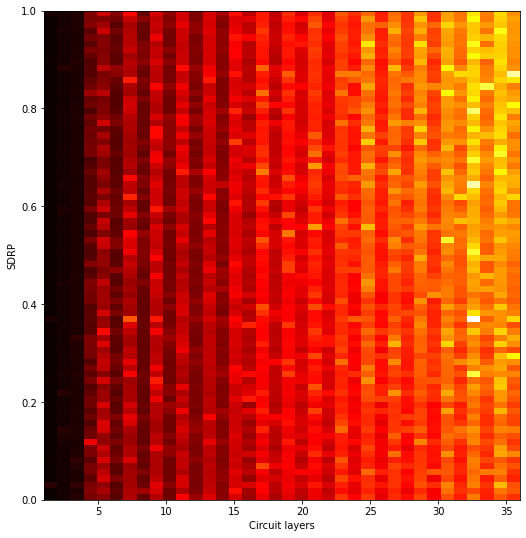

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (9, 9))
# plt.title("Fidelity vs. layer depth, 54 qubits, A100 GPU")
plt.xlabel("Circuit layers")
plt.ylabel("SDRP")

left = 1
right = 36
bottom = 0
top = 1
extent = [left, right, bottom, top]

h = qrack_time_results[36]

plt.imshow(h, cmap='hot', interpolation='nearest', extent=extent, aspect=36)

fig.savefig('heat_map_time_36.png', dpi=100)

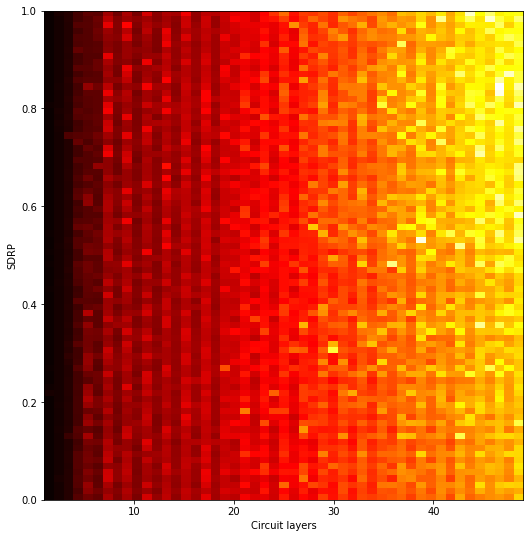

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (9, 9))
# plt.title("Fidelity vs. layer depth, 54 qubits, A100 GPU")
plt.xlabel("Circuit layers")
plt.ylabel("SDRP")

left = 1
right = 49
bottom = 0
top = 1
extent = [left, right, bottom, top]

h = qrack_time_results[49]

plt.imshow(h, cmap='hot', interpolation='nearest', extent=extent, aspect=49)

fig.savefig('heat_map_time_49.png', dpi=100)

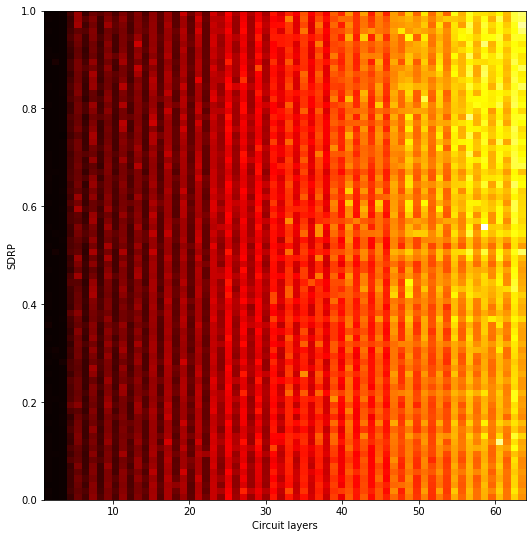

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (9, 9))
# plt.title("Fidelity vs. layer depth, 54 qubits, A100 GPU")
plt.xlabel("Circuit layers")
plt.ylabel("SDRP")

left = 1
right = 64
bottom = 0
top = 1
extent = [left, right, bottom, top]

h = qrack_time_results[64]

plt.imshow(h, cmap='hot', interpolation='nearest', extent=extent, aspect=64)

fig.savefig('heat_map_time_64.png', dpi=100)

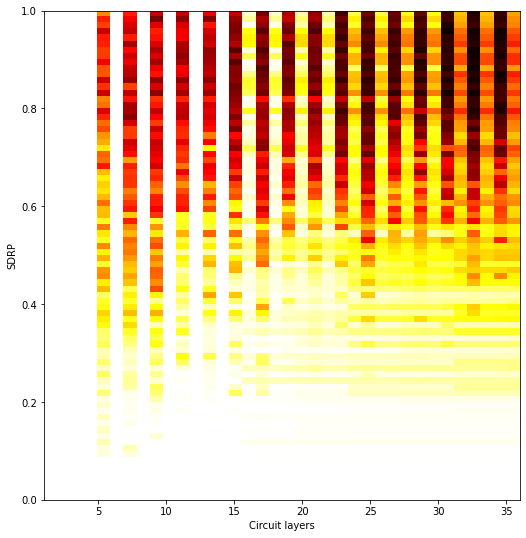

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (9, 9))
# plt.title("Fidelity vs. layer depth, 54 qubits, A100 GPU")
plt.xlabel("Circuit layers")
plt.ylabel("SDRP")

left = 1
right = 36
bottom = 0
top = 1
extent = [left, right, bottom, top]

h = qrack_fidelity_results[36]

plt.imshow(h, cmap='hot', interpolation='nearest', extent=extent, aspect=36)

fig.savefig('heat_map_fidelity_36.png', dpi=100)

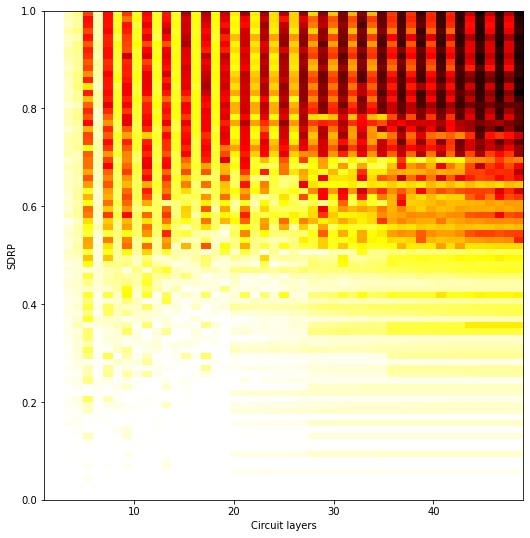

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (9, 9))
# plt.title("Fidelity vs. layer depth, 54 qubits, A100 GPU")
plt.xlabel("Circuit layers")
plt.ylabel("SDRP")

left = 1
right = 49
bottom = 0
top = 1
extent = [left, right, bottom, top]

h = qrack_fidelity_results[49]

plt.imshow(h, cmap='hot', interpolation='nearest', extent=extent, aspect=49)

fig.savefig('heat_map_fidelity_49.png', dpi=100)

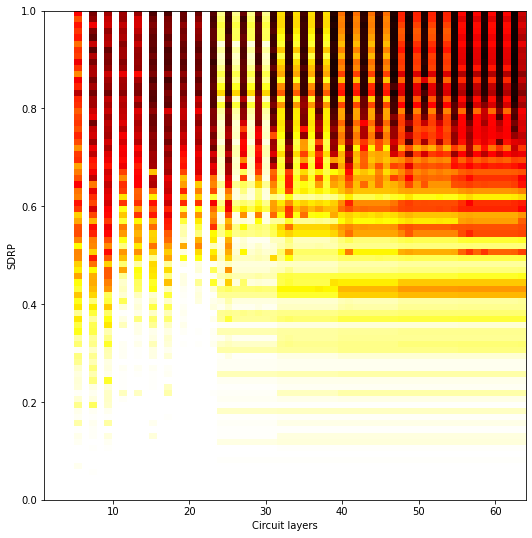

In [11]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (9, 9))
# plt.title("Fidelity vs. layer depth, 54 qubits, A100 GPU")
plt.xlabel("Circuit layers")
plt.ylabel("SDRP")

left = 1
right = 64
bottom = 0
top = 1
extent = [left, right, bottom, top]

h = qrack_fidelity_results[64]

plt.imshow(h, cmap='hot', interpolation='nearest', extent=extent, aspect=64)

fig.savefig('heat_map_fidelity_64.png', dpi=100)

In [12]:
import platform

print(platform.machine())
print(platform.version())
print(platform.platform())
print(platform.uname())
print(platform.system())
print(platform.processor())

x86_64
#43~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Fri Apr 21 16:51:08 UTC 2
Linux-5.19.0-42-generic-x86_64-with-glibc2.35
uname_result(system='Linux', node='sekhmet', release='5.19.0-42-generic', version='#43~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Fri Apr 21 16:51:08 UTC 2', machine='x86_64')
Linux
x86_64


In [13]:
import subprocess

line_as_bytes = subprocess.check_output("nvidia-smi -L", shell=True)
line = line_as_bytes.decode("ascii")
_, line = line.split(":", 1)
line, _ = line.split("(")
print(line.strip())

NVIDIA GeForce RTX 3080 Laptop GPU


In [14]:
import cpuinfo
cpuinfo.get_cpu_info()['brand_raw']

'Intel(R) Core(TM) i9-10980HK CPU @ 2.40GHz'